# Post-COVID Evaluation

In [31]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *

In [32]:
def add_truth(df, source='icosari', disease='sari', target=False):
    if target:
        df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/target-{source}-{disease}.csv')
    else:
        df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/latest_data-{source}-{disease}.csv')
        
    df_truth = df_truth.rename(columns={'value': 'truth'})

    df = df.merge(df_truth, how='left', 
                   left_on=['location', 'age_group', 'target_end_date'], 
                   right_on=['location', 'age_group', 'date'])
    return df

In [33]:
# files = glob.glob(f'../data/post-covid/submissions/**/*.csv', recursive=True)

In [34]:
def load_predictions(period='post-covid', start='2023-12-14', end='2024-09-19', include_median=True, include_truth=True, target=True):
    files = glob.glob(f'../data/{period}/submissions/**/*.csv', recursive=True)
    files = [f for f in files if '/old/' not in f]
    
    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file.split('/')[-1].split('-', 5)[-1][:-4] 
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    if include_median:
        df = add_median(df)
    if include_truth:
        df = add_truth(df, source='icosari', disease='sari', target=target)

    return df[df.forecast_date.between(start, end)]

In [44]:
df = load_predictions('post-covid')

In [36]:
df.model.unique()

array(['lightgbm', 'tsmixer', 'KIT-MeanEnsemble', 'KIT-hhh4'],
      dtype=object)

In [47]:
df.value = df.value.round()

In [41]:
df = df[df.forecast_date != '2023-12-28']

In [49]:
df

,location,age_group,forecast_date,target_end_date,horizon,type,quantile,value,model,year,week,date,truth
0,DE,00+,2024-04-11,2024-04-14,1,quantile,0.025,8447.0,lightgbm,2024.0,15.0,2024-04-14,11805.0
1,DE,00+,2024-04-11,2024-04-14,1,quantile,0.100,9751.0,lightgbm,2024.0,15.0,2024-04-14,11805.0
2,DE,00+,2024-04-11,2024-04-14,1,quantile,0.250,10300.0,lightgbm,2024.0,15.0,2024-04-14,11805.0
3,DE,00+,2024-04-11,2024-04-14,1,quantile,0.500,10621.0,lightgbm,2024.0,15.0,2024-04-14,11805.0
4,DE,00+,2024-04-11,2024-04-14,1,quantile,0.750,11636.0,lightgbm,2024.0,15.0,2024-04-14,11805.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42379,DE,60-79,2023-12-14,2024-01-07,4,median,0.500,4800.0,KIT-hhh4,2024.0,1.0,2024-01-07,4900.0
42380,DE,80+,2023-12-14,2023-12-17,1,median,0.500,5800.0,KIT-hhh4,2023.0,50.0,2023-12-17,5726.0
42381,DE,80+,2023-12-14,2023-12-24,2,median,0.500,6200.0,KIT-hhh4,2023.0,51.0,2023-12-24,5435.0
42382,DE,80+,2023-12-14,2023-12-31,3,median,0.500,6500.0,KIT-hhh4,2023.0,52.0,2023-12-31,6141.0


#### National level

In [42]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,KIT-MeanEnsemble,375.378256,176.752299,498.072558,1050.203113,0.3250,0.95000
1,tsmixer,422.037644,297.153600,438.320442,1157.511686,0.3625,0.90000
2,lightgbm,353.753374,58.201563,750.168161,1162.123098,0.4000,0.92500
3,KIT-hhh4,350.343750,445.522321,601.809821,1397.675893,0.2625,0.74375


In [7]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,KIT-MeanEnsemble,377.213995,172.441267,645.790626,1195.445889,0.317073,0.926829
1,lightgbm,357.971271,56.782013,853.531156,1268.284440,0.390244,0.908537
2,tsmixer,420.129774,289.905952,590.321422,1300.357148,0.353659,0.878049
3,KIT-hhh4,353.540941,434.655923,786.661150,1574.858014,0.256098,0.725610


#### Age groups

In [43]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,KIT-MeanEnsemble,84.752174,48.105467,79.646878,212.504518,0.429167,0.930208
1,lightgbm,60.934570,37.316600,144.896164,243.147333,0.277083,0.769792
2,KIT-hhh4,104.667411,88.066220,58.563542,251.297173,0.498958,0.930208
3,tsmixer,88.654541,63.662427,121.272705,273.589674,0.347917,0.756250


In [8]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,KIT-MeanEnsemble,84.707510,46.932163,102.817964,234.457637,0.418699,0.911585
1,lightgbm,61.954686,36.406439,160.874932,259.236057,0.273374,0.757114
2,KIT-hhh4,103.873403,85.918264,93.810685,283.602352,0.486789,0.909553
3,tsmixer,88.294441,62.109685,139.556386,289.960513,0.340447,0.742886


In [9]:
def compute_scores(df):
    # Apply the scoring function row-wise and round the result to 5 digits
    df_scores = (
        df.assign(score=lambda x: x.apply(lambda row: round(score(row['value'], row['truth'], row['type'], row['quantile']), 5), axis=1))
          .drop(columns=['value', 'truth'])
    )
    return df_scores

In [10]:
scores = compute_scores(df)

In [11]:
scores

,location,age_group,forecast_date,target_end_date,horizon,type,quantile,model,year,week,date,score
0,DE,00+,2024-04-11,2024-04-14,1,quantile,0.025,lightgbm,2024.0,15.0,2024-04-14,167.92324
1,DE,00+,2024-04-11,2024-04-14,1,quantile,0.100,lightgbm,2024.0,15.0,2024-04-14,410.74175
2,DE,00+,2024-04-11,2024-04-14,1,quantile,0.250,lightgbm,2024.0,15.0,2024-04-14,752.30481
3,DE,00+,2024-04-11,2024-04-14,1,quantile,0.500,lightgbm,2024.0,15.0,2024-04-14,1183.62674
4,DE,00+,2024-04-11,2024-04-14,1,quantile,0.750,lightgbm,2024.0,15.0,2024-04-14,253.49998
...,...,...,...,...,...,...,...,...,...,...,...,...
42379,DE,60-79,2023-12-14,2024-01-07,4,median,0.500,KIT-hhh4,2024.0,1.0,2024-01-07,100.00000
42380,DE,80+,2023-12-14,2023-12-17,1,median,0.500,KIT-hhh4,2023.0,50.0,2023-12-17,74.00000
42381,DE,80+,2023-12-14,2023-12-24,2,median,0.500,KIT-hhh4,2023.0,51.0,2023-12-24,765.00000
42382,DE,80+,2023-12-14,2023-12-31,3,median,0.500,KIT-hhh4,2023.0,52.0,2023-12-31,359.00000


In [12]:
# scores[(scores.age_group == '00+') & (scores.type == 'quantile')].groupby('model')['score'].mean()

# Plots

In [13]:
from plotnine import ggplot, aes, geom_bar, geom_label, scale_alpha_manual, labs, coord_flip, theme_bw, theme, geom_line, scale_alpha_discrete, guide_legend

In [14]:
df_national = evaluate_models(df, 'national')

In [15]:
df_age = evaluate_models(df, 'age')

In [16]:
scores_national = pd.melt(df_national, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

In [17]:
scores_age = pd.melt(df_age, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


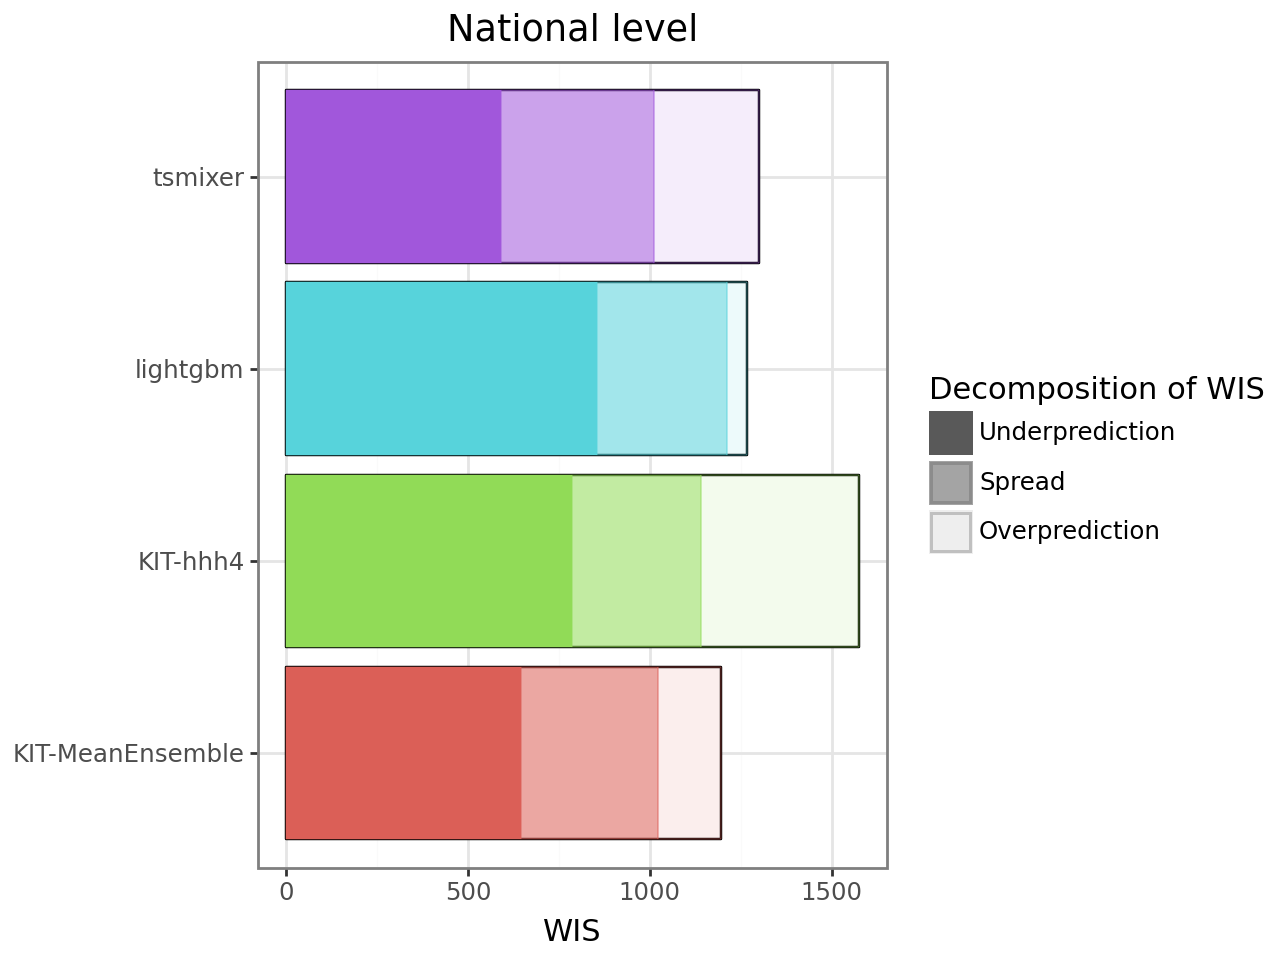

In [18]:
(ggplot()
    + geom_bar(df_national, aes(x='model', y='wis'), fill='white', color='black', stat='identity')
    + geom_bar(scores_national, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.1, stat='identity', 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS", title="National level")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='right')
   )

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


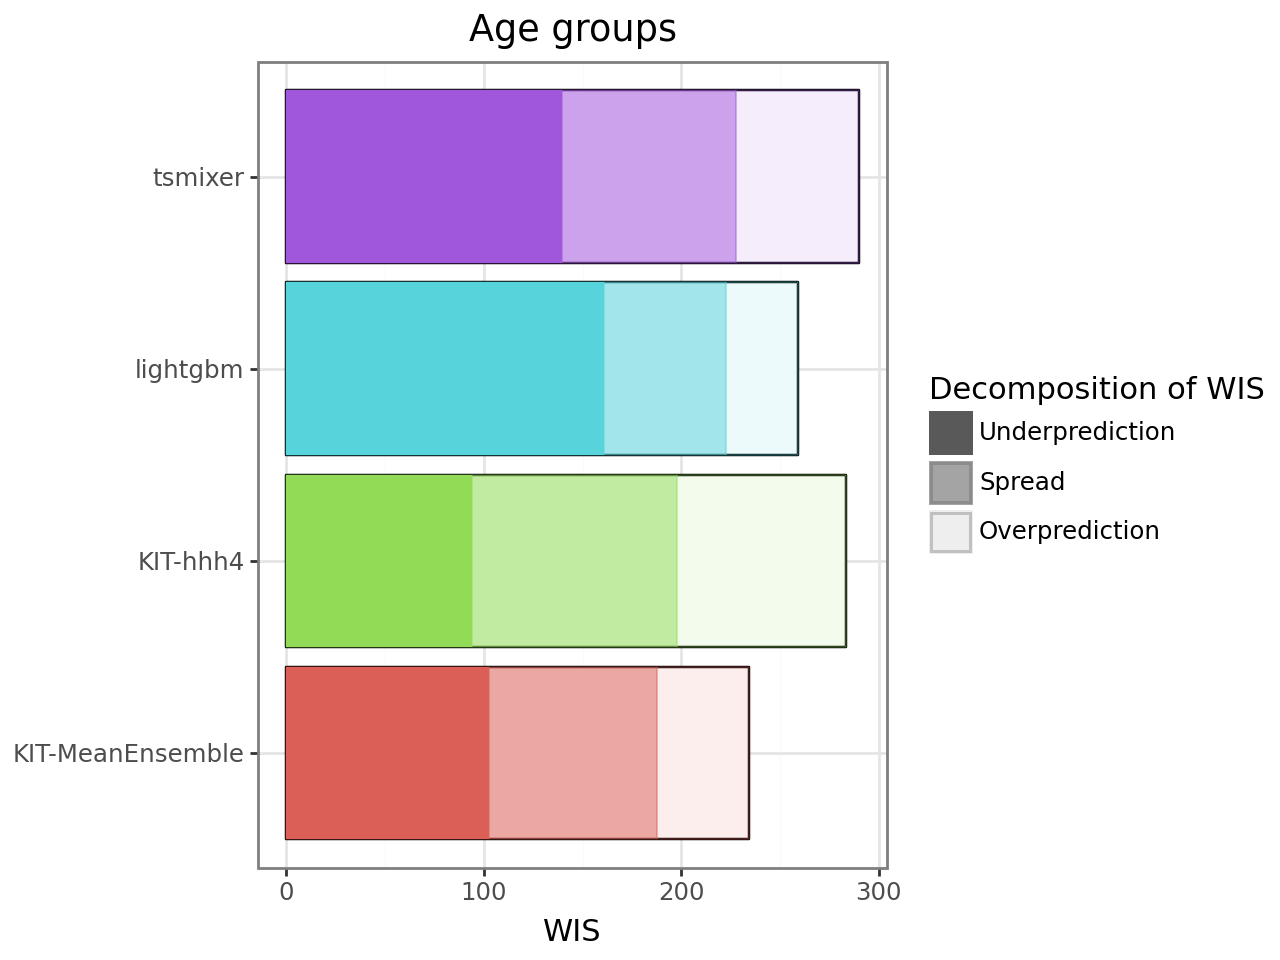

In [19]:
(ggplot()
    + geom_bar(df_age, aes(x='model', y='wis'), fill='white', color='black', stat='identity')
    + geom_bar(scores_age, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.1, stat='identity', 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS", title="Age groups")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='right')
   )

In [20]:
from plotnine import *
import matplotlib.pyplot as plt

In [21]:
def filter_scores(df, type="quantile", level="national", by_horizon=False, average=True):
    # Filter by type
    df = df[df['type'] == type]

    # Filter by level
    if level == "national":
        df = df[(df['location'] == "DE") & (df['age_group'] == "00+")]
    elif level == "states":
        df = df[(df['location'] != "DE")]
    elif level == "age":
        df = df[(df['location'] == "DE") & (df['age_group'] != "00+")]
                
    if by_horizon:
        if average:
            df = df.groupby(['model', 'horizon'], as_index=False).agg(score=('score', 'mean'))
            df = df.sort_values(by=['model', 'horizon'])
    else:
        if average:
            df = df.groupby(['model'], as_index=False).agg(score=('score', 'mean'))
        else:
            df = df.groupby(['model', 'location', 'age_group'], as_index=False).agg(score=('score', 'mean'))

    return df

In [22]:
def plot_scores_by_horizon(scores, level='national'):
    
    scores = filter_scores(scores, type='quantile', level=level, by_horizon=True, average=True)
    
    ylabel = "Mean WIS"

    plot = (
        ggplot(scores, aes(x='horizon', y='score', color='model')) +
        geom_line(size=1) +
        labs(
            x="Horizon (days)",
            y=ylabel,
            color="Model"
        ) +
        #scale_x_continuous(breaks=[i * -5 for i in range(6)], minor_breaks=range(-28, 1)) +
        scale_y_continuous(limits=(0, None)) +
        theme_bw() +
        theme(legend_position="right")
    )

    return plot

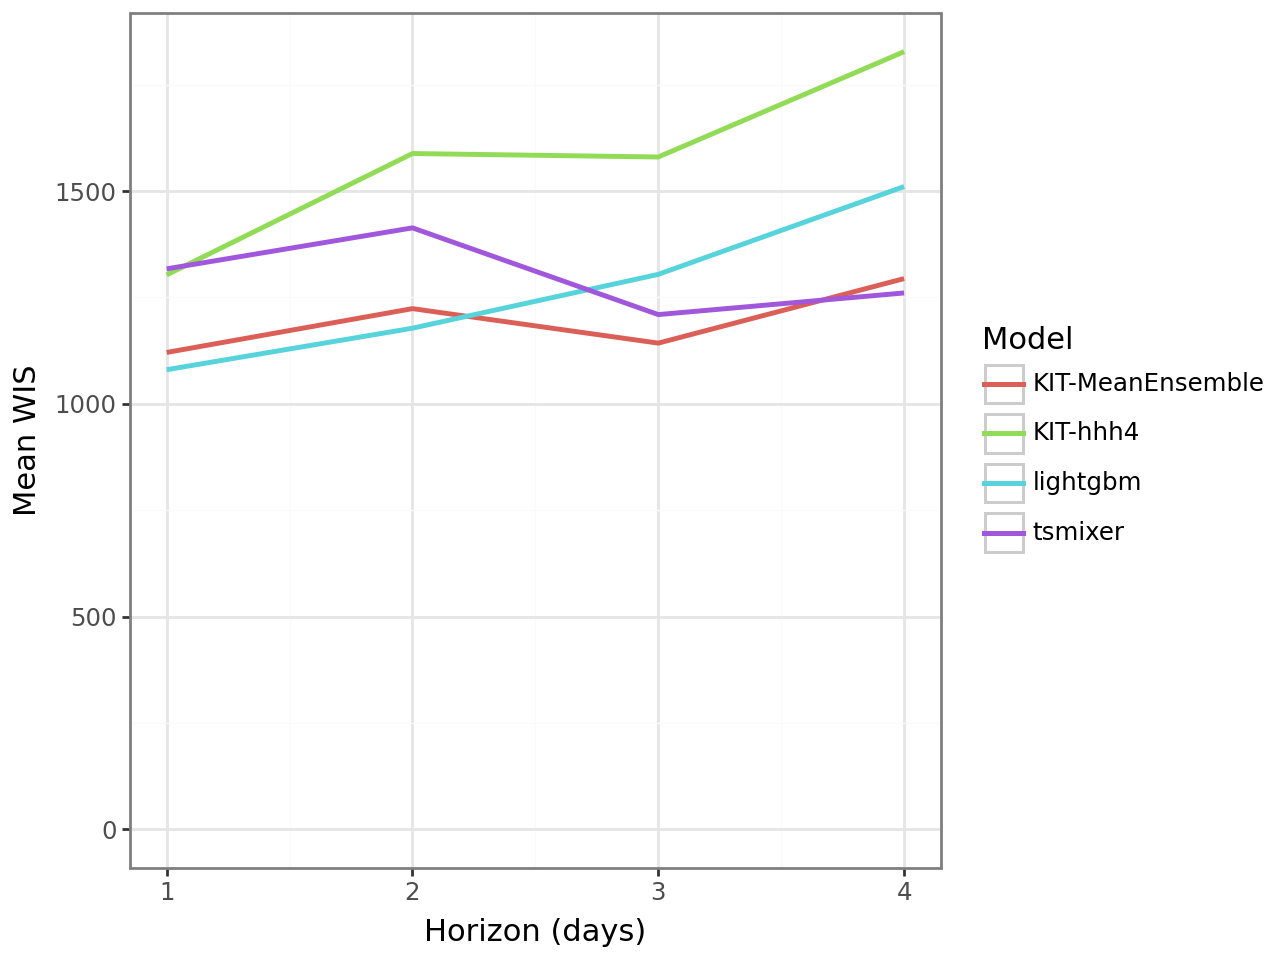

In [23]:
plot_scores_by_horizon(scores)

In [24]:
def plot_scores_by_horizon_and_model(scores, level='national'):
    scores = filter_scores(scores, type='quantile', level=level, by_horizon=True, average=True)
    
    # Sort the DataFrame by 'horizon' and 'score'
    scores = scores.sort_values(by=['horizon', 'score'])

    # Create a new column for sorted models within each horizon
    scores['model'] = pd.Categorical(scores['model'], 
                                      categories=scores.groupby('horizon')['model'].apply(lambda x: x.tolist()).explode().unique(),
                                      ordered=True)    
    plot = (
        ggplot(scores, aes(x='model', y='score', fill='model')) +
        geom_bar(stat='identity', position='dodge') +
        labs(
            x="Model",
            y="Score",
            title="Model Scores by Horizon"
        ) +
        facet_wrap('~horizon', nrow=1) +  # Create a facet for each horizon
        theme_bw() +
        theme(
            axis_text_x=element_text(rotation=45, ha="right"),
            legend_position='none'
        ) 
    )
    return plot

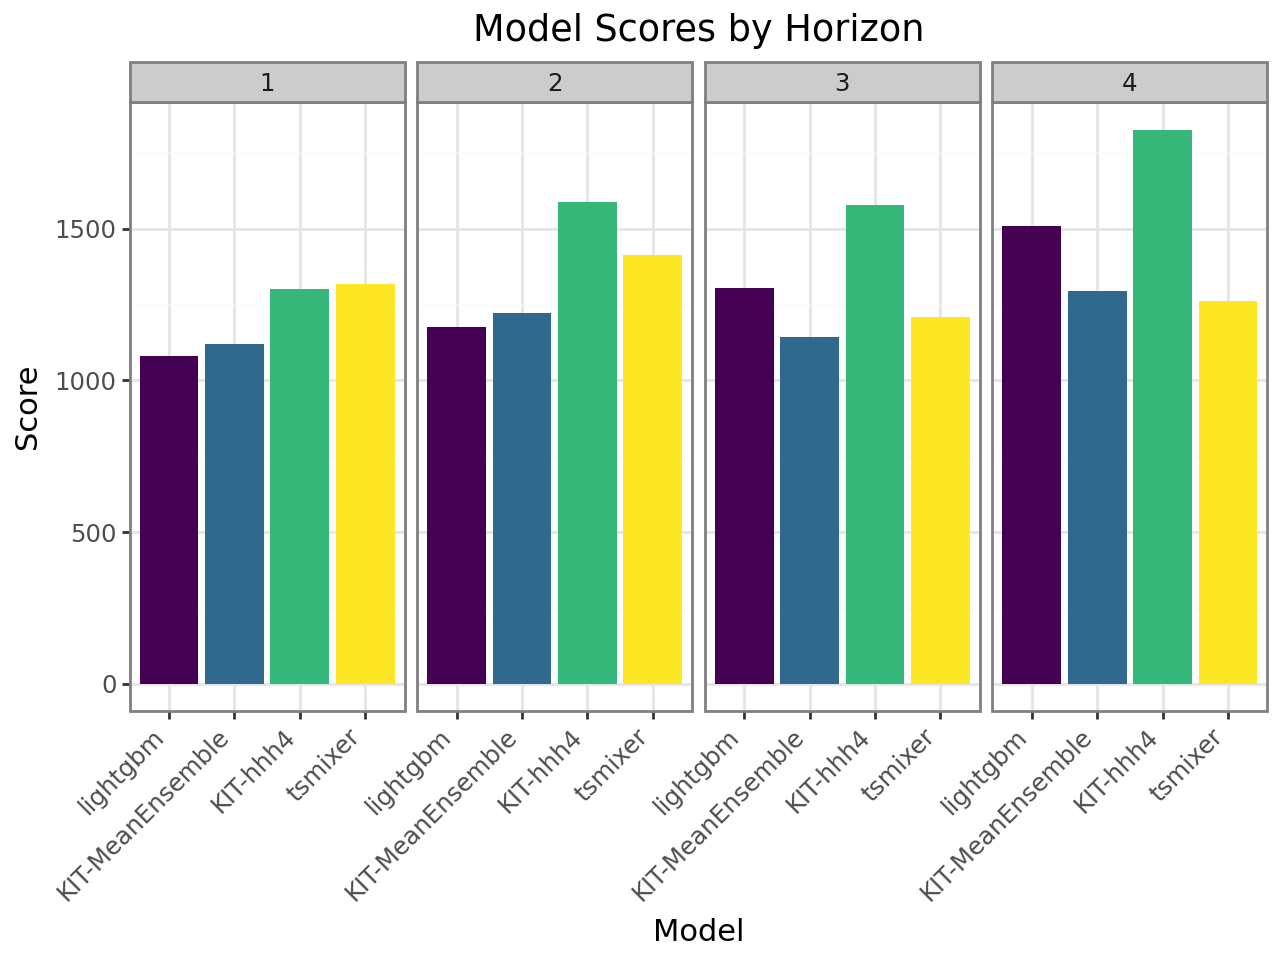

In [25]:
plot_scores_by_horizon_and_model(scores)

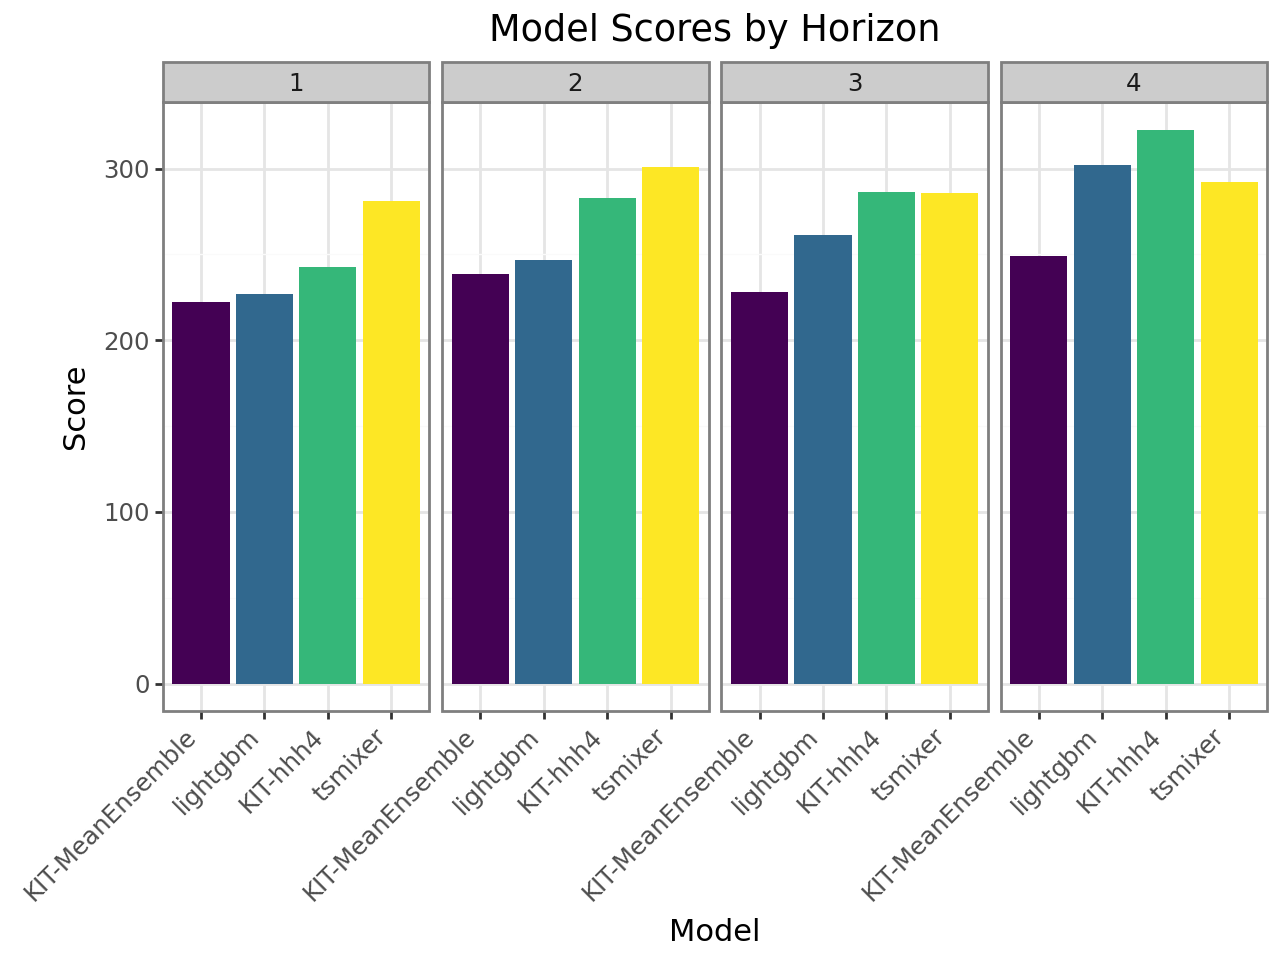

In [26]:
plot_scores_by_horizon_and_model(scores, level='age')

In [27]:
scores_age = filter_scores(scores, type='quantile', level='age', by_horizon=False, average=False)

In [28]:
scores_age.sort_values('age_group')

,model,location,age_group,score
0,KIT-MeanEnsemble,DE,00-04,243.310684
12,lightgbm,DE,00-04,277.443654
18,tsmixer,DE,00-04,273.800745
6,KIT-hhh4,DE,00-04,308.507840
13,lightgbm,DE,05-14,200.721128
7,KIT-hhh4,DE,05-14,137.139373
19,tsmixer,DE,05-14,250.216212
1,KIT-MeanEnsemble,DE,05-14,141.999758
8,KIT-hhh4,DE,15-34,150.392857
2,KIT-MeanEnsemble,DE,15-34,163.726044


In [29]:
def plot_scores_by_age_group(df):
    plot = (
        ggplot(df, aes(x='model', y='score', fill='model')) +
        geom_bar(stat='identity', position='dodge') +
        labs(
            x="Model",
            y="Mean WIS",
            title="WIS by age group"
        ) +
        facet_wrap('~age_group') +
        theme_bw() +
        theme(
            #axis_text_x=element_text(rotation=45, ha="right"),
            legend_position='none'
        )
    )
    return plot

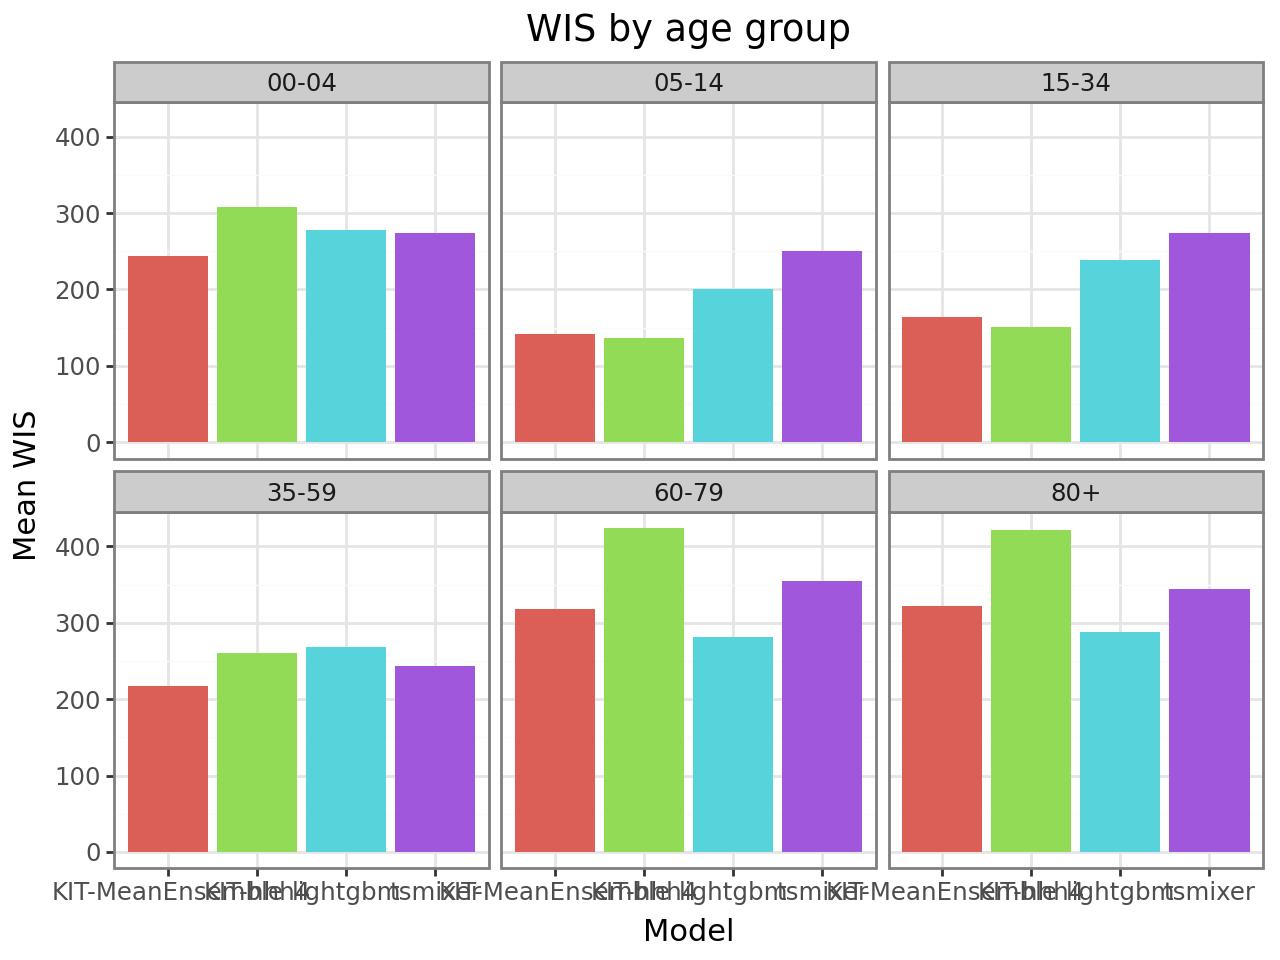

In [30]:
plot_scores_by_age_group(scores_age)